In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import warnings
import umap
warnings.filterwarnings('ignore')

c:\Users\Mateo Vasquez\Desktop\Proyectos\Censo2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_clusters = pd.read_parquet('output/dataset_con_clusters.parquet')
df_original = pd.read_parquet('output/dataset_final_con_nombres.parquet')

In [4]:
# Extraer datos para reduccion dimensional
X_scaled = df_clusters.drop(columns=['cluster_final', 'cluster_kmeans_k5', 
                                      'cluster_hdbscan', 'pca1', 'pca2'], 
                             errors='ignore').values

labels = df_clusters['cluster_final'].values

# Filtrar outliers si existen
mask_no_outliers = labels != -1
X_clean = X_scaled[mask_no_outliers]
labels_clean = labels[mask_no_outliers]

print(f"\nDatos para visualizacion:")
print(f"   Hogares: {len(X_clean):,}")
print(f"   Variables: {X_clean.shape[1]}")
print(f"   Clusters: {len(set(labels_clean))}")



Datos para visualizacion:
   Hogares: 57,366
   Variables: 168
   Clusters: 5


In [5]:
# Configurar UMAP
reducer_umap = umap.UMAP(
    n_neighbors=15,        # Vecinos para estructura local
    min_dist=0.1,          # Distancia minima entre puntos
    n_components=2,        # 2D para visualizacion
    metric='euclidean',    # Misma metrica que K-means
    random_state=42,       # Reproducibilidad
    verbose=True           # Mostrar progreso
)

# Fit transform
X_umap = reducer_umap.fit_transform(X_clean)

print("\nUMAP completado")
print(f"   Shape: {X_umap.shape}")
print(f"   Rango UMAP1: [{X_umap[:, 0].min():.2f}, {X_umap[:, 0].max():.2f}]")
print(f"   Rango UMAP2: [{X_umap[:, 1].min():.2f}, {X_umap[:, 1].max():.2f}]")

UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Nov 22 11:58:50 2025 Construct fuzzy simplicial set
Sat Nov 22 11:58:50 2025 Finding Nearest Neighbors
Sat Nov 22 11:58:50 2025 Building RP forest with 17 trees
Sat Nov 22 11:58:58 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Nov 22 11:59:25 2025 Finished Nearest Neighbor Search
Sat Nov 22 11:59:31 2025 Construct embedding


Epochs completed:   0%|            1/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:10]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:17]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [00:25]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:33]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [00:42]

	completed  100  /  200 epochs


Epochs completed:  61%| ██████     122/200 [00:50]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [00:58]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [01:06]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [01:15]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [01:23]

Sat Nov 22 12:01:04 2025 Finished embedding

UMAP completado
   Shape: (57366, 2)
   Rango UMAP1: [-7.22, 22.57]
   Rango UMAP2: [-9.34, 13.90]


In [6]:
print("\n" + "="*80)
print("RECALCULAR PCA PARA COMPARACION")
print("="*80)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clean)

print(f"\nPCA completado")
print(f"   Varianza explicada PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   Varianza explicada PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Varianza total: {pca.explained_variance_ratio_.sum()*100:.2f}%")


RECALCULAR PCA PARA COMPARACION

PCA completado
   Varianza explicada PC1: 59.10%
   Varianza explicada PC2: 17.31%
   Varianza total: 76.41%



Visualizacion guardada: comparacion_pca_umap.png


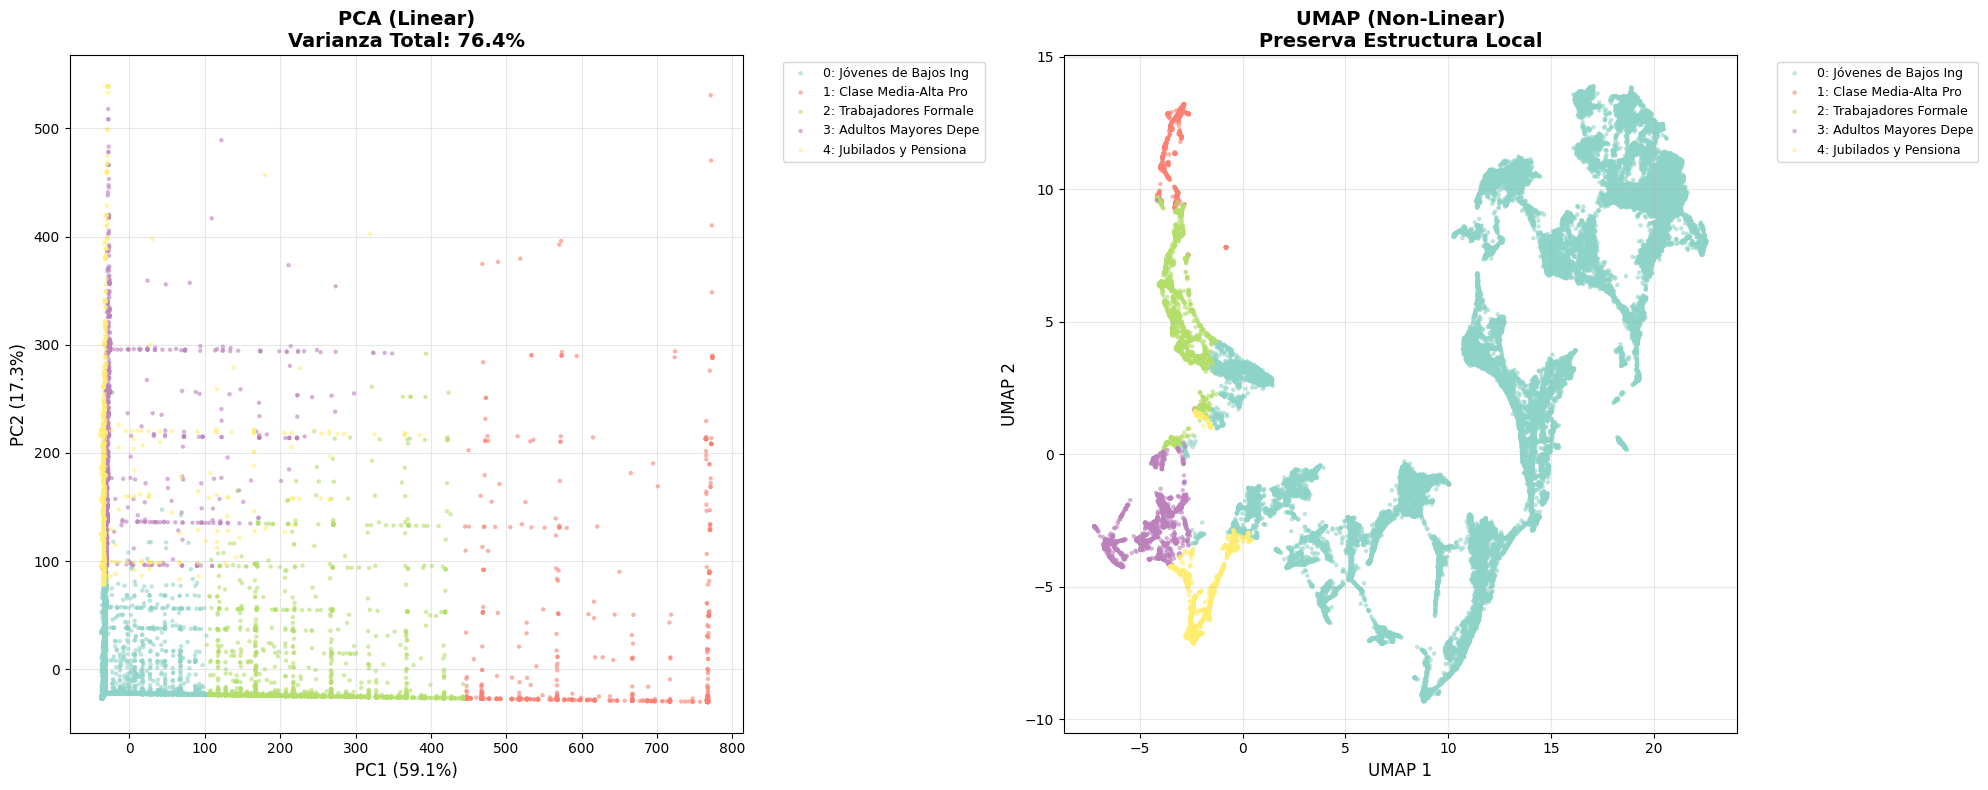


VISUALIZACION UMAP POR CLUSTER INDIVIDUAL

Visualizacion guardada: umap_clusters_individual.png


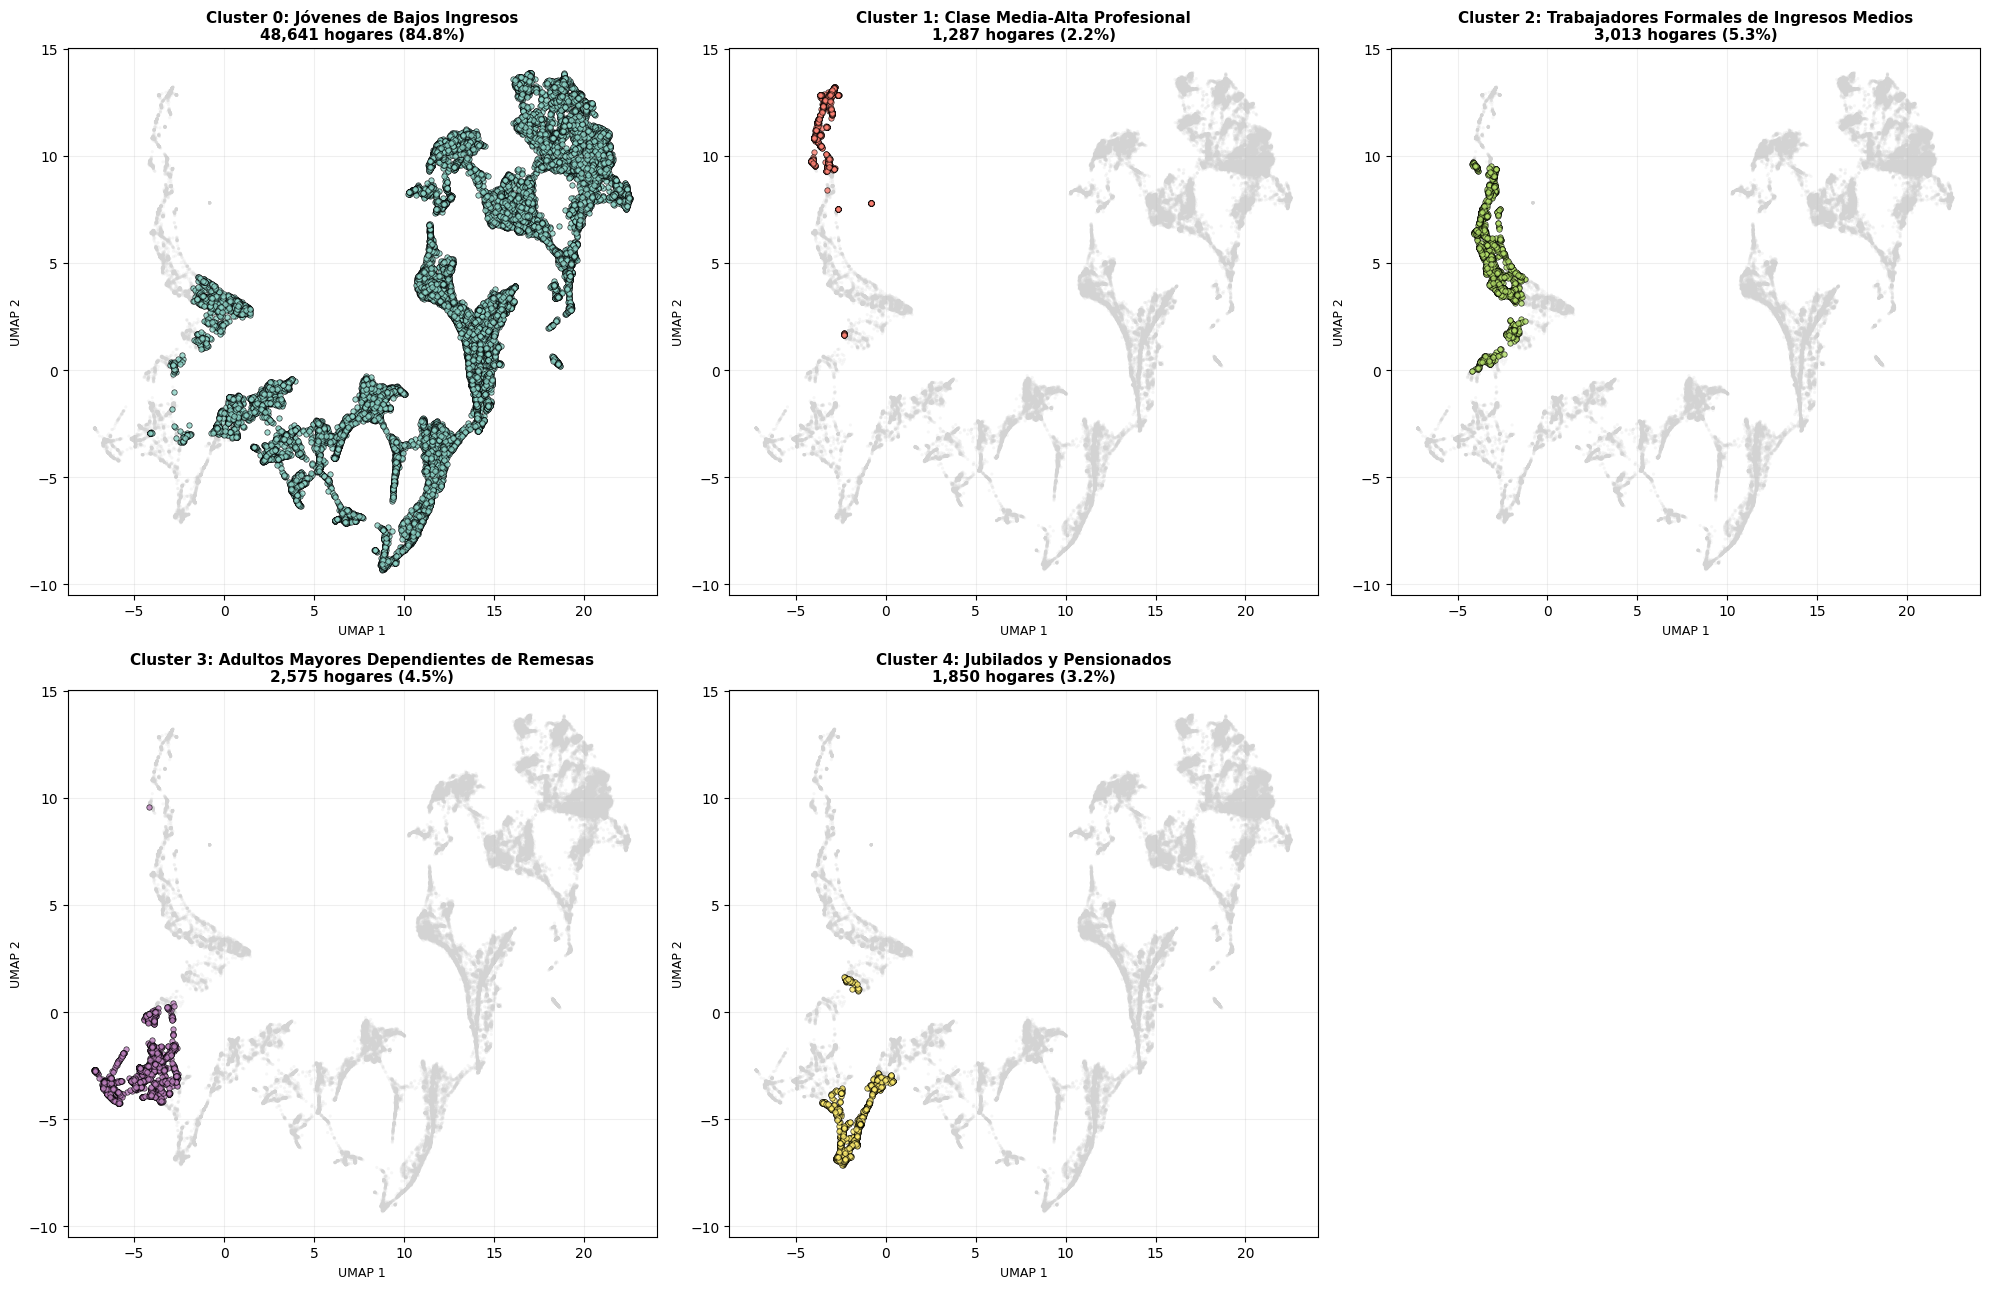

In [7]:
# Cargar nombres de clusters
df_perfiles = pd.read_csv('output/perfiles_detallados.csv')
nombres_clusters = df_perfiles.set_index('Cluster')['Nombre'].to_dict()

# Colores consistentes
n_clusters = len(set(labels_clean))
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --------------------------------------------------
# SUBPLOT 1: PCA
# --------------------------------------------------
ax1 = axes[0]

for cluster_id in sorted(set(labels_clean)):
    mask = labels_clean == cluster_id
    nombre = nombres_clusters.get(cluster_id, f"Cluster {cluster_id}")
    
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[cluster_id]], 
                label=f"{cluster_id}: {nombre[:20]}",
                alpha=0.6, 
                s=10,
                edgecolors='none')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title('PCA (Linear)\nVarianza Total: {:.1f}%'.format(
    pca.explained_variance_ratio_.sum()*100), 
    fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# --------------------------------------------------
# SUBPLOT 2: UMAP
# --------------------------------------------------
ax2 = axes[1]

for cluster_id in sorted(set(labels_clean)):
    mask = labels_clean == cluster_id
    nombre = nombres_clusters.get(cluster_id, f"Cluster {cluster_id}")
    
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1],
                c=[colors[cluster_id]], 
                label=f"{cluster_id}: {nombre[:20]}",
                alpha=0.6, 
                s=10,
                edgecolors='none')

ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.set_title('UMAP (Non-Linear)\nPreserva Estructura Local', 
              fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparacion_pca_umap.png', 
            dpi=150, bbox_inches='tight')
print("\nVisualizacion guardada: comparacion_pca_umap.png")
plt.show()


print("\n" + "="*80)
print("VISUALIZACION UMAP POR CLUSTER INDIVIDUAL")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.flatten()

for idx, cluster_id in enumerate(sorted(set(labels_clean))):
    if idx < len(axes):
        ax = axes[idx]
        
        # Todos los puntos en gris
        ax.scatter(X_umap[:, 0], X_umap[:, 1], 
                   c='lightgray', alpha=0.2, s=5, edgecolors='none')
        
        # Cluster destacado
        mask = labels_clean == cluster_id
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1],
                   c=[colors[cluster_id]], 
                   alpha=0.8, 
                   s=15,
                   edgecolors='black',
                   linewidths=0.5)
        
        nombre = nombres_clusters.get(cluster_id, f"Cluster {cluster_id}")
        n_hogares = mask.sum()
        pct = (n_hogares / len(labels_clean)) * 100
        
        ax.set_title(f'Cluster {cluster_id}: {nombre}\n{n_hogares:,} hogares ({pct:.1f}%)', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('UMAP 1', fontsize=9)
        ax.set_ylabel('UMAP 2', fontsize=9)
        ax.grid(True, alpha=0.2)

# Ocultar subplot extra si hay
for idx in range(len(set(labels_clean)), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('images/umap_clusters_individual.png', 
            dpi=150, bbox_inches='tight')
print("\nVisualizacion guardada: umap_clusters_individual.png")
plt.show()


In [8]:
print("GUARDAR COORDENADAS UMAP")
print("="*80)
df_viz = df_original[df_original['cluster'] != -1].copy()
# Agregar coordenadas UMAP al dataset
df_viz['umap1'] = X_umap[:, 0]
df_viz['umap2'] = X_umap[:, 1]
df_viz['pca1'] = X_pca[:, 0]
df_viz['pca2'] = X_pca[:, 1]

# Guardar
df_viz.to_parquet('output/dataset_con_umap_pca.parquet',
                  compression='snappy', index=False)

print("\nDataset con coordenadas guardado: dataset_con_umap_pca.parquet")
print(f"   Variables agregadas: umap1, umap2, pca1, pca2")

GUARDAR COORDENADAS UMAP

Dataset con coordenadas guardado: dataset_con_umap_pca.parquet
   Variables agregadas: umap1, umap2, pca1, pca2


Clusters a visualizar: [0, 1, 2, 3, 4]
Total de clusters: 5

Piramides de edad guardadas: piramides_edad.png


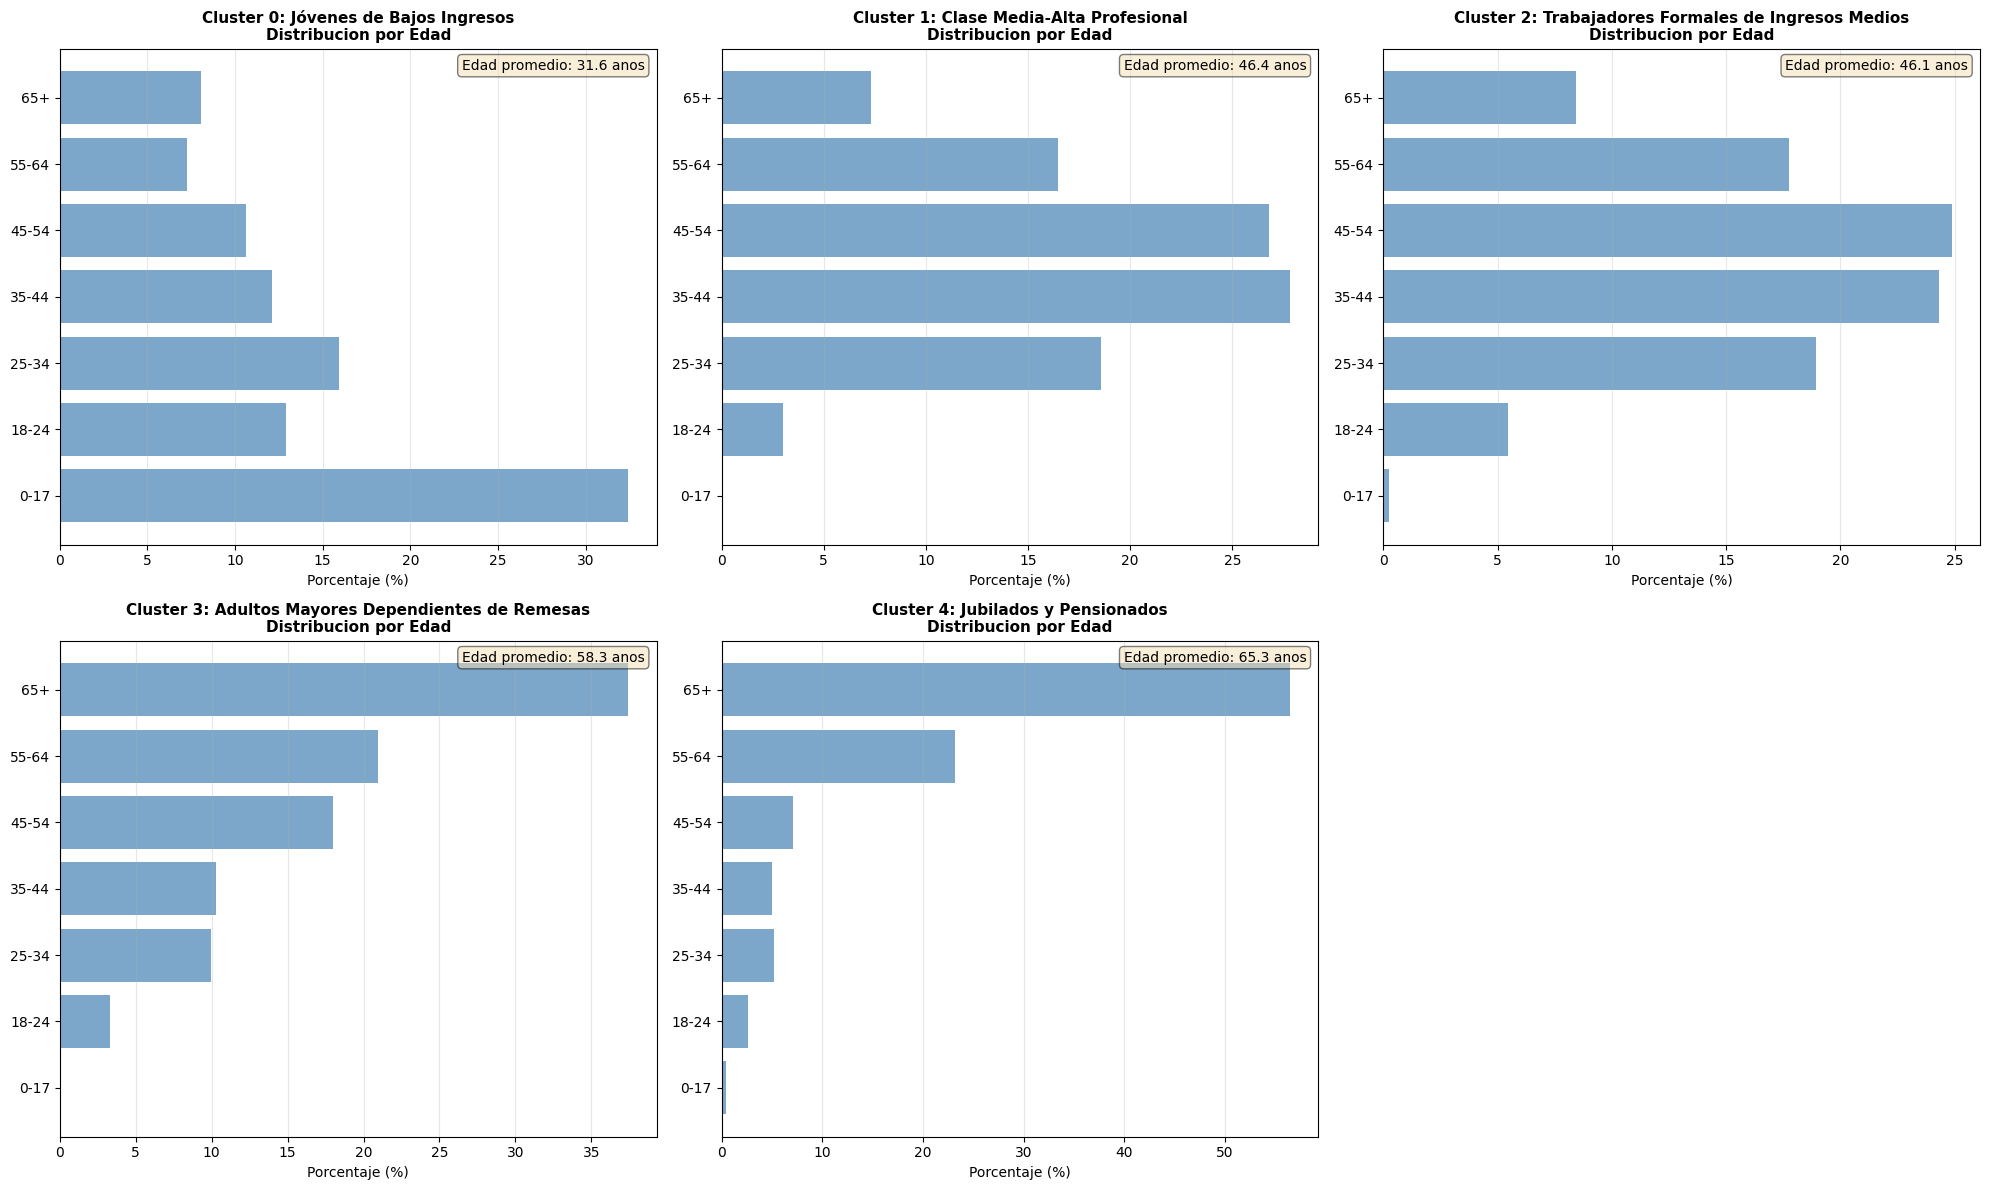

In [9]:
df_viz = pd.read_parquet('output/dataset_con_umap_pca.parquet')
df_perfiles = pd.read_csv('output/perfiles_detallados.csv')

if 'edad' in df_viz.columns:
    # Crear rangos de edad
    bins_edad = [0, 18, 25, 35, 45, 55, 65, 120]
    labels_edad = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    
    df_viz['rango_edad'] = pd.cut(df_viz['edad'], bins=bins_edad, labels=labels_edad)
    
    # Contar cuantos clusters reales hay
    clusters_reales = [c for c in sorted(df_viz['cluster'].unique()) if c != -1]
    clusters_title = [x.item() for x in clusters_reales]
    n_clusters = len(clusters_reales)
    
    print(f"Clusters a visualizar: {clusters_title}")
    print(f"Total de clusters: {n_clusters}")
    
    # Crear piramides por cluster
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, cluster_id in enumerate(clusters_reales):
        ax = axes[idx]
        
        cluster_data = df_viz[df_viz['cluster'] == cluster_id]
        nombre = df_perfiles[df_perfiles['Cluster'] == cluster_id]['Nombre'].values[0]
        
        # Contar por rango de edad
        edad_counts = cluster_data['rango_edad'].value_counts().sort_index()
        total = len(cluster_data)
        edad_pct = (edad_counts / total * 100)
        
        # Grafico horizontal
        y_pos = np.arange(len(edad_pct))
        ax.barh(y_pos, edad_pct.values, color='steelblue', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(edad_pct.index)
        ax.set_xlabel('Porcentaje (%)', fontsize=10)
        ax.set_title(f'Cluster {cluster_id}: {nombre}\nDistribucion por Edad', 
                    fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Agregar edad promedio
        edad_prom = cluster_data['edad'].mean()
        ax.text(0.98, 0.98, f'Edad promedio: {edad_prom:.1f} anos',
               transform=ax.transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    for idx in range(n_clusters, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('images/piramides_edad.png', dpi=150, bbox_inches='tight')
    print("\nPiramides de edad guardadas: piramides_edad.png")
    plt.show()
else:
    print("\nVariable edad no disponible")


3. COMPOSICION DE FUENTES DE INGRESO

Composicion de ingresos guardada: composicion_ingresos.png


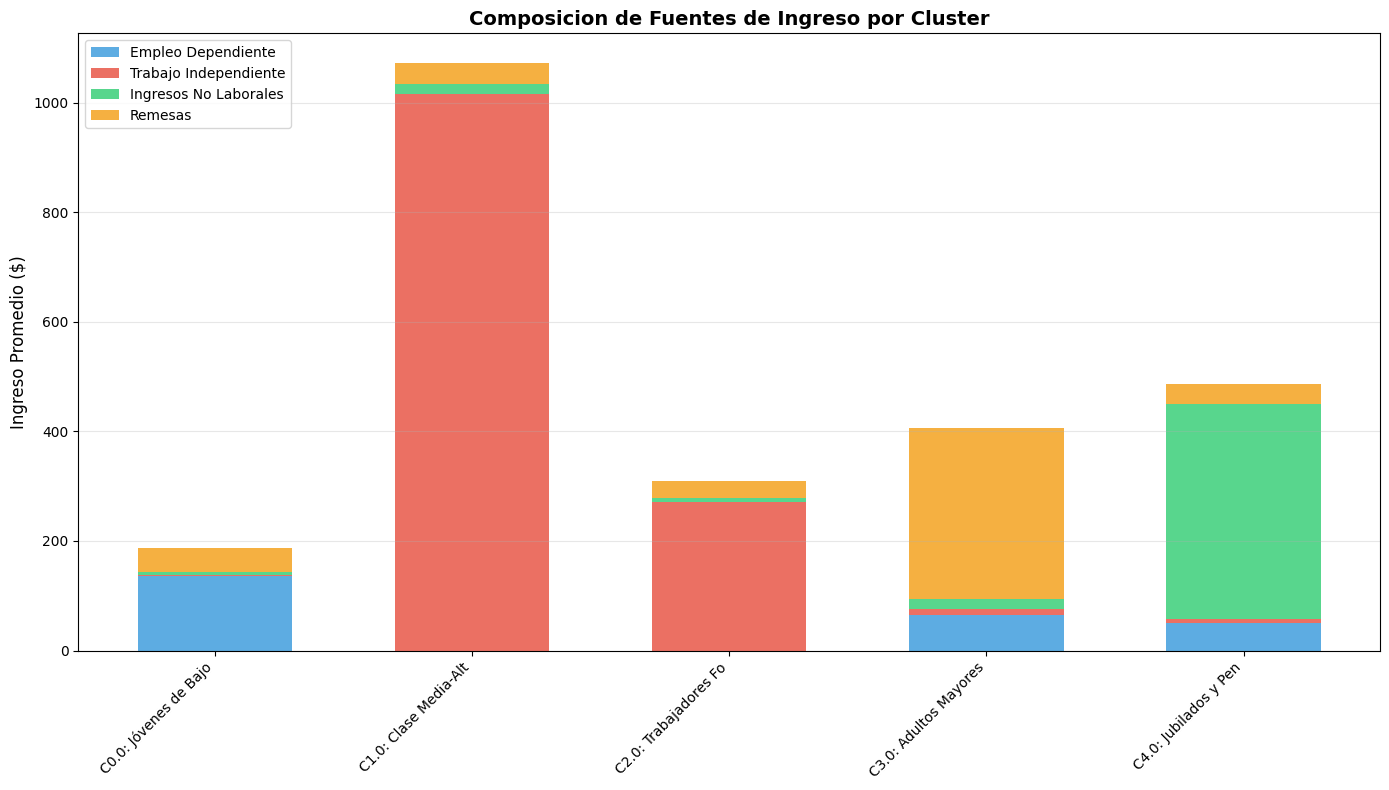

In [10]:
print("\n" + "="*80)
print("3. COMPOSICION DE FUENTES DE INGRESO")
print("="*80)

fuentes_ingreso = ['imeds', 'ingreso_independientes', 'imnl', 'totayuda']
fuentes_disponibles = [f for f in fuentes_ingreso if f in df_viz.columns]

if len(fuentes_disponibles) >= 3:
    # Calcular promedios por cluster
    composicion = []
    
    for cluster_id in sorted(df_viz['cluster'].unique()):
        if cluster_id != -1:
            cluster_data = df_viz[df_viz['cluster'] == cluster_id]
            
            row = {'Cluster': cluster_id}
            for fuente in fuentes_disponibles:
                row[fuente] = cluster_data[fuente].mean()
            
            composicion.append(row)
    
    df_composicion = pd.DataFrame(composicion)
    
    # Grafico de barras apiladas
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Preparar datos para stacked bar
    x = np.arange(len(df_composicion))
    width = 0.6
    
    # Nombres cortos
    nombres_fuentes = {
        'imeds': 'Empleo Dependiente',
        'ingreso_independientes': 'Trabajo Independiente',
        'imnl': 'Ingresos No Laborales',
        'totayuda': 'Remesas'
    }
    
    # Colores
    colores = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    # Crear barras apiladas
    bottom = np.zeros(len(df_composicion))
    
    for idx, fuente in enumerate(fuentes_disponibles):
        valores = df_composicion[fuente].values
        ax.bar(x, valores, width, label=nombres_fuentes.get(fuente, fuente),
               bottom=bottom, color=colores[idx], alpha=0.8)
        bottom += valores
    
    # Personalizar
    cluster_labels = [f"C{row['Cluster']}: {df_perfiles[df_perfiles['Cluster']==row['Cluster']]['Nombre'].values[0][:15]}"
                     for _, row in df_composicion.iterrows()]
    
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_labels, rotation=45, ha='right')
    ax.set_ylabel('Ingreso Promedio ($)', fontsize=12)
    ax.set_title('Composicion de Fuentes de Ingreso por Cluster', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('images/composicion_ingresos.png', 
                dpi=150, bbox_inches='tight')
    print("\nComposicion de ingresos guardada: composicion_ingresos.png")
    plt.show()



4. MATRIZ DE PRIORIZACION DE POLITICAS

Matriz de priorizacion guardada: matriz_priorizacion.png


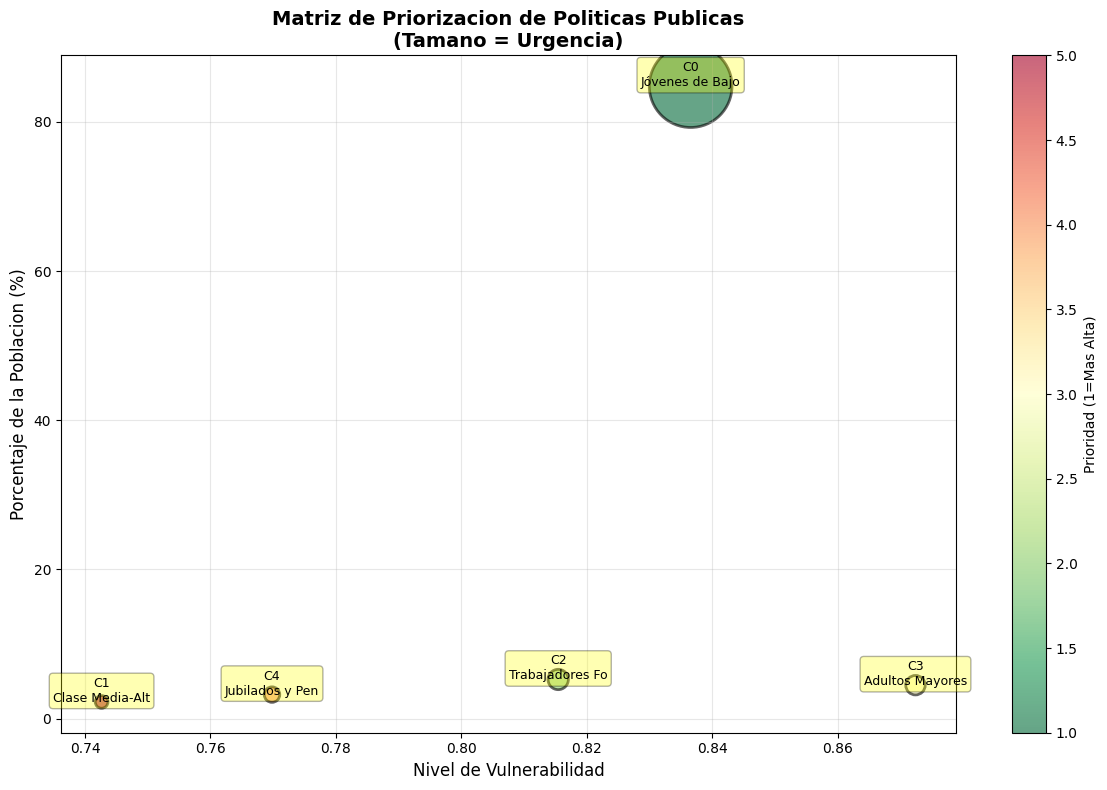

In [11]:
print("\n" + "="*80)
print("4. MATRIZ DE PRIORIZACION DE POLITICAS")
print("="*80)

# Crear matriz de priorizacion
priorizacion = []

for cluster_id in sorted(df_viz['cluster'].unique()):
    if cluster_id != -1:
        cluster_data = df_viz[df_viz['cluster'] == cluster_id]
        perfil = df_perfiles[df_perfiles['Cluster'] == cluster_id].iloc[0]
        
        # Calcular scores de prioridad
        tamano_pct = len(cluster_data) / len(df_viz) * 100
        
        # Vulnerabilidad (inverso de ingreso + baja educacion)
        vulnerabilidad = 0
        if 'ingpe' in df_viz.columns:
            ingreso_norm = 1 - (cluster_data['ingpe'].mean() / df_viz['ingpe'].max())
            vulnerabilidad += ingreso_norm * 0.5
        
        if 'aproba1' in df_viz.columns:
            educacion_norm = 1 - (cluster_data['aproba1'].mean() / df_viz['aproba1'].max())
            vulnerabilidad += educacion_norm * 0.5
        
        # Urgencia (combinacion de factores)
        urgencia = vulnerabilidad * (tamano_pct / 100)
        
        priorizacion.append({
            'Cluster': cluster_id,
            'Nombre': perfil['Nombre'],
            'Poblacion_Pct': tamano_pct,
            'Vulnerabilidad': vulnerabilidad,
            'Urgencia': urgencia,
            'Prioridad': None
        })

df_priorizacion = pd.DataFrame(priorizacion)

# Asignar prioridad
df_priorizacion = df_priorizacion.sort_values('Urgencia', ascending=False)
df_priorizacion['Prioridad'] = range(1, len(df_priorizacion) + 1)

# Visualizar matriz
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df_priorizacion['Vulnerabilidad'], 
                    df_priorizacion['Poblacion_Pct'],
                    s=df_priorizacion['Urgencia']*5000,
                    c=df_priorizacion['Prioridad'],
                    cmap='RdYlGn_r',
                    alpha=0.6,
                    edgecolors='black',
                    linewidths=2)

# Etiquetas
for idx, row in df_priorizacion.iterrows():
    ax.annotate(f"C{row['Cluster']}\n{row['Nombre'][:15]}",
               (row['Vulnerabilidad'], row['Poblacion_Pct']),
               fontsize=9,
               ha='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Nivel de Vulnerabilidad', fontsize=12)
ax.set_ylabel('Porcentaje de la Poblacion (%)', fontsize=12)
ax.set_title('Matriz de Priorizacion de Politicas Publicas\n(Tamano = Urgencia)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Prioridad (1=Mas Alta)', fontsize=10)

plt.tight_layout()
plt.savefig('images/matriz_priorizacion.png', dpi=150, bbox_inches='tight')
print("\nMatriz de priorizacion guardada: matriz_priorizacion.png")
plt.show()

In [12]:
# Crear tabla resumen completa
resumen_ejecutivo = []

for cluster_id in sorted(df_viz['cluster'].unique()):
    if cluster_id != -1:
        cluster_data = df_viz[df_viz['cluster'] == cluster_id]
        perfil = df_perfiles[df_perfiles['Cluster'] == cluster_id].iloc[0]
        
        resumen = {
            'Cluster': cluster_id,
            'Perfil': perfil['Nombre'],
            'Hogares': len(cluster_data),
            'Pct_Poblacion': f"{len(cluster_data)/len(df_viz)*100:.1f}%"
        }
        
        # Indicadores clave
        if 'edad' in df_viz.columns:
            resumen['Edad_Prom'] = f"{cluster_data['edad'].mean():.1f}"
        
        if 'ingpe' in df_viz.columns:
            resumen['Ingreso_PC'] = f"${cluster_data['ingpe'].mean():.2f}"
        
        if 'aproba1' in df_viz.columns:
            resumen['Educacion'] = f"{cluster_data['aproba1'].mean():.1f} anos"
        
        if 'h411a' in df_viz.columns:
            resumen['Horas_Trabajo'] = f"{cluster_data['h411a'].mean():.1f}h/sem"
        
        # Fuente principal de ingreso
        fuentes = {}
        if 'imeds' in df_viz.columns:
            fuentes['Emp. Depend.'] = cluster_data['imeds'].mean()
        if 'ingreso_independientes' in df_viz.columns:
            fuentes['Trab. Indep.'] = cluster_data['ingreso_independientes'].mean()
        if 'imnl' in df_viz.columns:
            fuentes['No Laboral'] = cluster_data['imnl'].mean()
        if 'totayuda' in df_viz.columns:
            fuentes['Remesas'] = cluster_data['totayuda'].mean()
        
        if fuentes:
            fuente_principal = max(fuentes.items(), key=lambda x: x[1])
            resumen['Fuente_Principal'] = fuente_principal[0]
        
        resumen_ejecutivo.append(resumen)

df_resumen = pd.DataFrame(resumen_ejecutivo)

display(df_resumen)

,Cluster,Perfil,Hogares,Pct_Poblacion,Edad_Prom,Ingreso_PC,Educacion,Horas_Trabajo,Fuente_Principal
0,0,Jóvenes de Bajos Ingresos,48641,84.8%,31.6,$197.32,6.8 anos,16.3h/sem,Emp. Depend.
1,1,Clase Media-Alta Profesional,1287,2.2%,46.4,$500.49,9.3 anos,49.3h/sem,Trab. Indep.
2,2,Trabajadores Formales de Ingresos Medios,3013,5.3%,46.1,$219.14,7.7 anos,43.9h/sem,Trab. Indep.
3,3,Adultos Mayores Dependientes de Remesas,2575,4.5%,58.3,$235.41,4.7 anos,12.8h/sem,Remesas
4,4,Jubilados y Pensionados,1850,3.2%,65.3,$373.78,8.8 anos,6.2h/sem,No Laboral
